# Ellipsoid Lightcurves Period Comparison

This notebook is used for comparing the periods before and after ellipsoid crossing times of variable stars.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, QTable, vstack
import os

from astroquery.gaia import Gaia

import sys
sys.path.append('..')
import ellipsoid
import lightCurve

from astropy.timeseries import LombScargle, TimeSeries
import random

### Read in the desired file and set global parameters
If using the ```ellipsoid.py``` script to download Gaia data, the file names are:

```GCNS_var``` -- variable stars in GCNS

```Gaia_var``` -- variable stars in Gaia DR3

```GCNS``` -- stars in GCNS

```Gaia``` -- stars in Gaia DR3

The tolerance is in lightyears, and the default start time is the time of the first Gaia alert

In [2]:
file_name = '../Gaia_var_class'
c1, stars = ellipsoid.readFile(file_name)
tol = 0.1

The default event (i.e. the second focal point of the SETI Ellipsoid) is SN 1987A by default, and its parameters are set below

In [3]:
#Properties of SN1987A
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err = 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [4]:
len(c1)

9322432

### Get table of crossing stars

```c1_x``` contains astropy SkyCoord objects of each star that has crossed (within some tolerance) the ellipsoid since the start time

```stars_x``` is a table with all the relevant information for each of the stars

In [5]:
c1_x, stars_x = ellipsoid.crossErrorEllipsoid(c0, t0, c1, stars, tol)
print(f'{len(stars_x)} stars have crossed the ellipsoid during Gaia DR3 data collection time')

217 stars have crossed the ellipsoid during Gaia DR3 data collection time


### Login to Gaia archive

Creating and logging into a Gaia archive account allows for larger data downloads

You can register here:
https://www.cosmos.esa.int/web/gaia-users/register

In [7]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: anilipou
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


### Split the desired stars into chunks of =< 5000 (if needed)

Datalink, the protocol Gaia uses for ancillary data such as epoch photometry and spectra, can only retrieve data for up to 5000 sources at a time. This threshold is overcome by splitting the input into chunks of size =< 5000 sources.

In [8]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [9]:
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = stars_x['id']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')

* Input list contains 217 source_IDs
* This list is split into 1 chunks of <= 5000 elements each


### Get lightcurves

When downloading, light curves will all be in one table (merged).

Can also save and read light curve tables once downloaded.

In [10]:
retrieval_type = 'EPOCH_PHOTOMETRY'        # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS' 
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW' - but as explained above, we strongly recommend to use COMBINED for massive downloads.
data_release   = 'Gaia DR3'   # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'


ii = 0
for chunk in ids_chunks:
    ii = ii + 1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk, data_release = data_release, retrieval_type=retrieval_type, format = 'votable', data_structure = data_structure)
    datalink_all.append(datalink)

In [11]:
temp = [inp[dl_key][0].to_table() for inp in datalink_all]
merged = vstack(temp)

Save downloaded table

In [ ]:
#merged_sf = '../GCNS_var_lc.xml'

#if os.path.exists(merged_sf):
#    os.remove(merged_sf)    
#QTable(merged).write(merged_sf, format='votable')

Read saved table

In [13]:
#lc_merged = QTable.read(merged_sf, format='votable')

### Make dictionaries for each band

Each source is observed in three bands by Gaia (G, RP, BP), so here we create a dictionary for each band, with the keys equal to the source IDs and the values equal to the light curve table for that source and band

In [12]:
glcDict = {}
bplcDict = {}
rplcDict = {}

In [13]:
for sid in ids:
    glc, bplc, rplc = lightCurve.getLC(merged, sid, 'G'), lightCurve.getLC(merged, sid, 'BP'), lightCurve.getLC(merged, sid, 'RP')
    glcDict[str(sid)], bplcDict[str(sid)], rplcDict[str(sid)] = glc, bplc, rplc

### Check variable classes

In [14]:
lcChoices = list(glcDict.keys())

In [15]:
lcClasses = ellipsoid.varClasses(tuple(lcChoices))

INFO: Query finished. [astroquery.utils.tap.core]


See the unique classes

In [19]:
set(lcClasses['best_class_name'])

{'DSCT|GDOR|SXPHE', 'ECL', 'RS', 'SOLAR_LIKE', 'WD'}

## Eclipsing Binaries

In [20]:
lcClasses[lcClasses['best_class_name'] == 'ECL']

best_class_name,source_id
bytes30,int64
ECL,4785503589711841280
ECL,4929395130250439168
ECL,5793290899490805888


Pick a desired source ID

In [74]:
lcID = 4785503589711841280
id_mask = stars_x['id'] == lcID

Get the ellipsoid crossing time for the selected star, as well as the light curve information

In [75]:
xtime = ellipsoid.xTime(c1_x[id_mask])[0]

In [76]:
lcDict = glcDict # choose g, bp, or rp light curve

lcTimes = Time(lcDict[str(lcID)]['time'].value + 2455197.5, format='jd')
lcFlux = lcDict[str(lcID)]['flux']
lcFerr = lcDict[str(lcID)]['flux_error']
lcMag = lcDict[str(lcID)]['mag']
# time offset described at https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_photometry/ssec_dm_epoch_photometry.html

#### Plot with crossing time

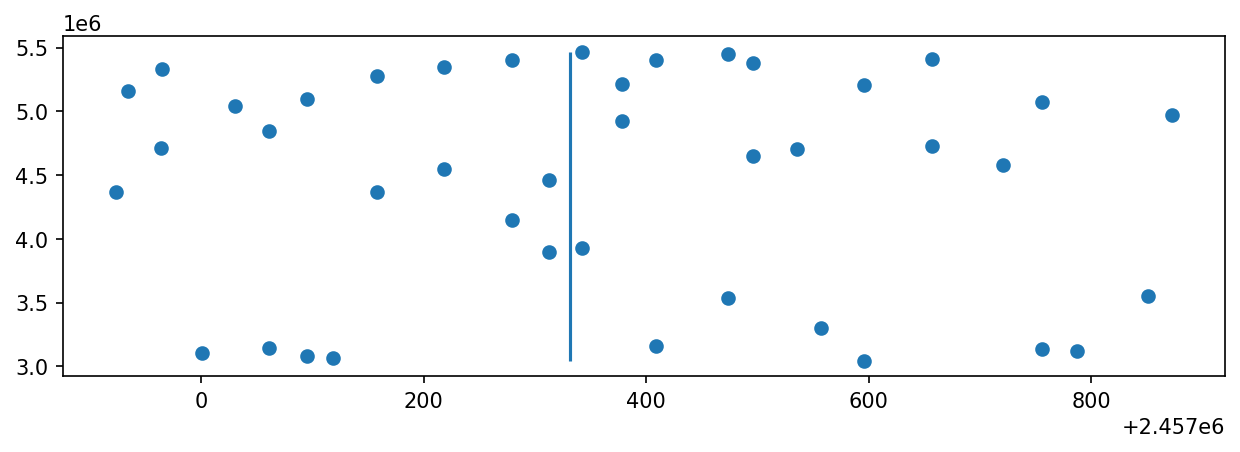

In [77]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)

In [78]:
lcTS = TimeSeries(time = lcTimes, data={'flux' : lcFlux/np.median(lcFlux), 'flux_error' : lcFerr/np.median(lcFlux)})

Text(0, 0.5, 'Power')

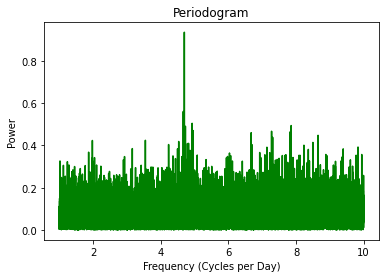

In [79]:
freqs = np.linspace(1/u.d, 10/u.d, 10000)
power = LombScargle(lcTS.time, lcTS['flux'], lcTS['flux_error']).power(freqs)
best_freq = freqs[np.argmax(power)]

plt.plot(freqs, power, color='g')
plt.title('Periodogram')
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Power')

We use double the period because we are trying to fit a double gaussian

In [80]:
lcTS_folded = lcTS.fold(period=2./best_freq, normalize_phase=True, epoch_phase=0)

Text(0, 0.5, 'Normalized Flux')

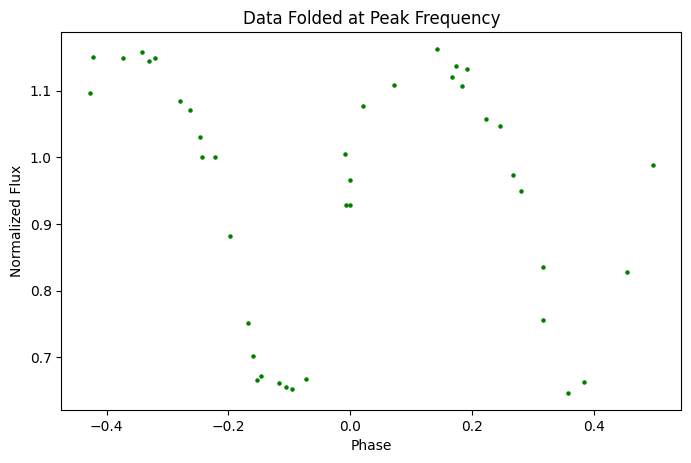

In [81]:
fig = plt.figure(figsize=(8,5), dpi=100)

plt.scatter(lcTS_folded['time'], lcTS_folded['flux'], c = 'g', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [82]:
from scipy.optimize import curve_fit

In [83]:
def negDoubleGaussian(x, mu1, sig1, d1, mu2, sig2, d2, b):
    g1 = d1*np.exp(-np.power(x - mu1, 2.) / (2 * np.power(sig1, 2.)))
    g2 = d2*np.exp(-np.power(x - mu2, 2.) / (2 * np.power(sig2, 2.)))
    ndg = -g1 - g2 + b
    return ndg

In [200]:
p0 = np.array([-0.15, 0.1, 0.5, 0.4, 0.1, 0.5, 1.15])
p1, cov1 = curve_fit(negDoubleGaussian, lcTS_folded['time'].value, lcTS_folded['flux'].value, p0, maxfev=10000)

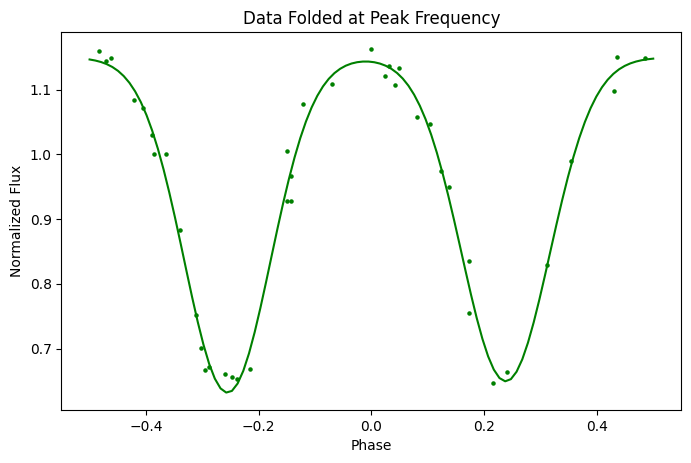

In [199]:
fig = plt.figure(figsize=(8,5), dpi=100)

plt.scatter(lcTS_folded['time'], lcTS_folded['flux'], c = 'g', s=5)
plt.title('Data Folded at Peak Frequency')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

xs = np.linspace(-0.5, 0.5, 100)
plt.plot(xs, negDoubleGaussian(xs, p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6]), c='g')

### Compare Before and After

In [91]:
right_mask = lcTimes.value > xtime
left_mask = lcTimes.value <= xtime

In [188]:
lcTS_right = TimeSeries(time = lcTimes[right_mask], data={'flux' : lcFlux[right_mask]/np.median(lcFlux[right_mask]), 'flux_error' : lcFerr[right_mask]/np.median(lcFlux[right_mask])})
lcTS_left = TimeSeries(time = lcTimes[left_mask], data={'flux' : lcFlux[left_mask]/np.median(lcFlux[left_mask]), 'flux_error' : lcFerr[left_mask]/np.median(lcFlux[left_mask])})

Text(0, 0.5, 'Power')

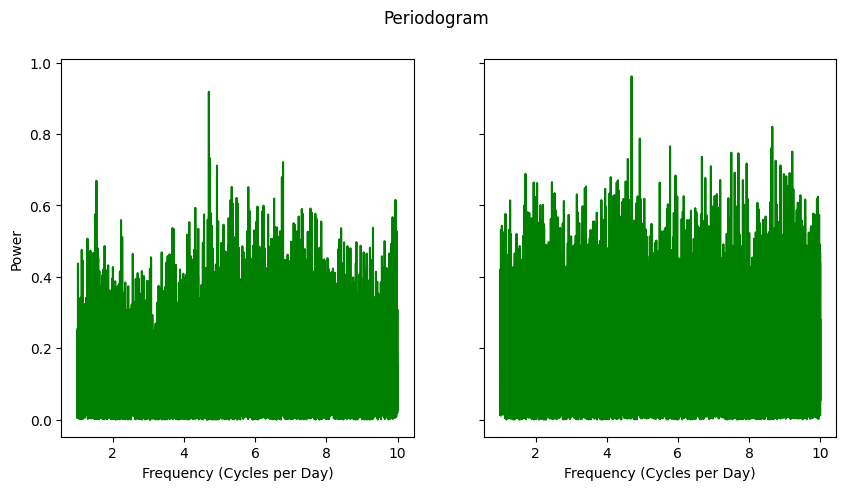

In [249]:
freqs = np.linspace(1/u.d, 10/u.d, 10000)
power_right = LombScargle(lcTS_right.time, lcTS_right['flux'], lcTS_right['flux_error']).power(freqs)
power_left = LombScargle(lcTS_left.time, lcTS_left['flux'], lcTS_left['flux_error']).power(freqs)

best_freq_right = freqs[np.argmax(power_right)]
best_freq_left = freqs[np.argmax(power_left)]

fig, ax = plt.subplots(1,2, figsize=[10,5], dpi=100, sharey=True)

ax[0].plot(freqs, power_left, color='g')
ax[1].plot(freqs, power_right, color='g')
fig.suptitle('Periodogram')
ax[0].set_xlabel('Frequency (Cycles per Day)')
ax[1].set_xlabel('Frequency (Cycles per Day)')
ax[0].set_ylabel('Power')

In [250]:
lcTS_folded_right = lcTS_right.fold(period=2./best_freq_right, normalize_phase=True, epoch_phase=0)
lcTS_folded_left = lcTS_left.fold(period=2./best_freq_left, normalize_phase=True, epoch_time=lcTS_left['time'][np.where(lcTS_left['flux']==np.max(lcTS_left['flux']))[0][0]])

Text(0, 0.5, 'Normalized Flux')

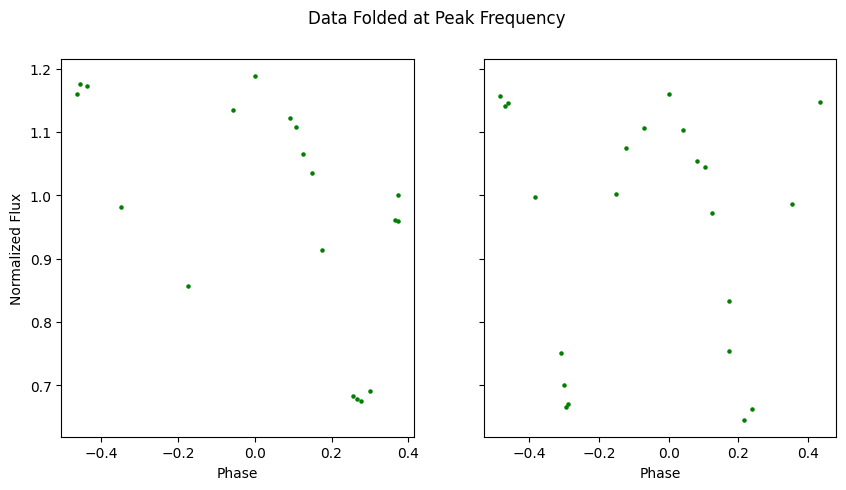

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100, sharey=True)

ax[0].scatter(lcTS_folded_left['time'], lcTS_folded_left['flux'], c = 'g', s=5)
ax[1].scatter(lcTS_folded_right['time'], lcTS_folded_right['flux'], c = 'g', s=5)
fig.suptitle('Data Folded at Peak Frequency')
ax[0].set_xlabel('Phase')
ax[1].set_xlabel('Phase')
ax[0].set_ylabel('Normalized Flux')

In [252]:
print(f'Left Period: {2./best_freq_left}')
print(f'Right Period: {2./best_freq_right}')

Left Period: 0.4257520597815673 d
Right Period: 0.4257520597815673 d


In [253]:
best_freq_left/2

<Quantity 2.34878488 1 / d>

`lightCurve.py` has a function to fit a double Gaussian

In [256]:
pLeft, lcTS_folded_left = lightCurve.fitDoubleGaussian(lcTS_left, best_freq_left)
pRight, lcTS_folded_right = lightCurve.fitDoubleGaussian(lcTS_right, best_freq_right)

Text(0, 0.5, 'Normalized Flux')

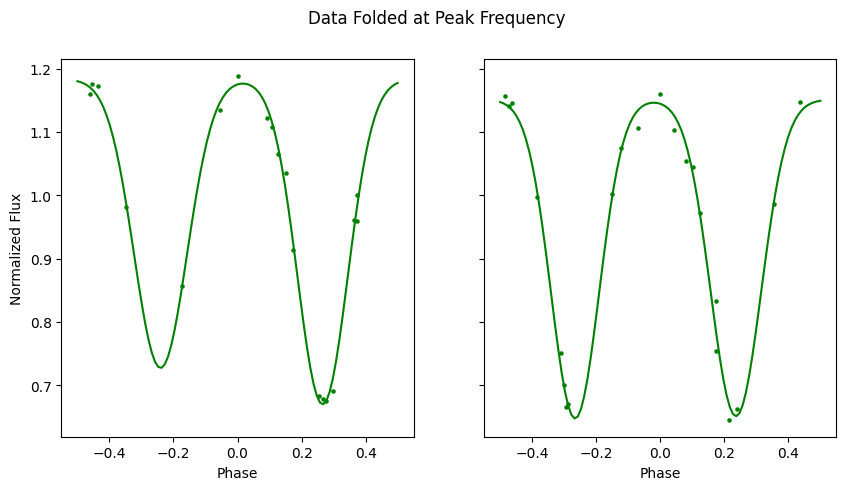

In [257]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100, sharey=True)

ax[0].scatter(lcTS_folded_left['time'], lcTS_folded_left['flux'], c = 'g', s=5)
ax[1].scatter(lcTS_folded_right['time'], lcTS_folded_right['flux'], c = 'g', s=5)

ax[0].plot(xs, negDoubleGaussian(xs, pLeft[0], pLeft[1], pLeft[2], pLeft[3], pLeft[4], pLeft[5], pLeft[6]), c='g')
ax[1].plot(xs, negDoubleGaussian(xs, pRight[0], pRight[1], pRight[2], pRight[3], pRight[4], pRight[5], pRight[6]), c='g')

fig.suptitle('Data Folded at Peak Frequency')
ax[0].set_xlabel('Phase')
ax[1].set_xlabel('Phase')
ax[0].set_ylabel('Normalized Flux')

### Produce periodograms for all 217 stars

In [278]:
set(lcClasses['best_class_name'])

{'DSCT|GDOR|SXPHE', 'ECL', 'RS', 'SOLAR_LIKE', 'WD'}

In [297]:
for row in lcClasses[lcClasses['best_class_name'] == 'ECL']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=True, savefolder='Periodograms/ECL')

In [301]:
for row in lcClasses[lcClasses['best_class_name'] == 'SOLAR_LIKE']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=True, savefolder='Periodograms/Solar')
    except:
        print(lcID)

3177407910705445888
4858215766828595968
4873746132349363328
5125414998097353600
5152365363828101632
5330165258852192896
5366183335638901888
5407414407508441856
5544523919794889088
5878380317661078912


In [298]:
for row in lcClasses[lcClasses['best_class_name'] == 'DSCT|GDOR|SXPHE']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=True, savefolder='Periodograms/DSCT')
    except:
        print(lcID)

In [299]:
for row in lcClasses[lcClasses['best_class_name'] == 'RS']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=True, savefolder='Periodograms/RS')
    except:
        print(lcID)

5811866422581688320


In [300]:
for row in lcClasses[lcClasses['best_class_name'] == 'WD']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=True, savefolder='Periodograms/WD')
    except:
        print(lcID)

5620763437599189376
6462911897617050240


### For periodic variables, compare other parameters

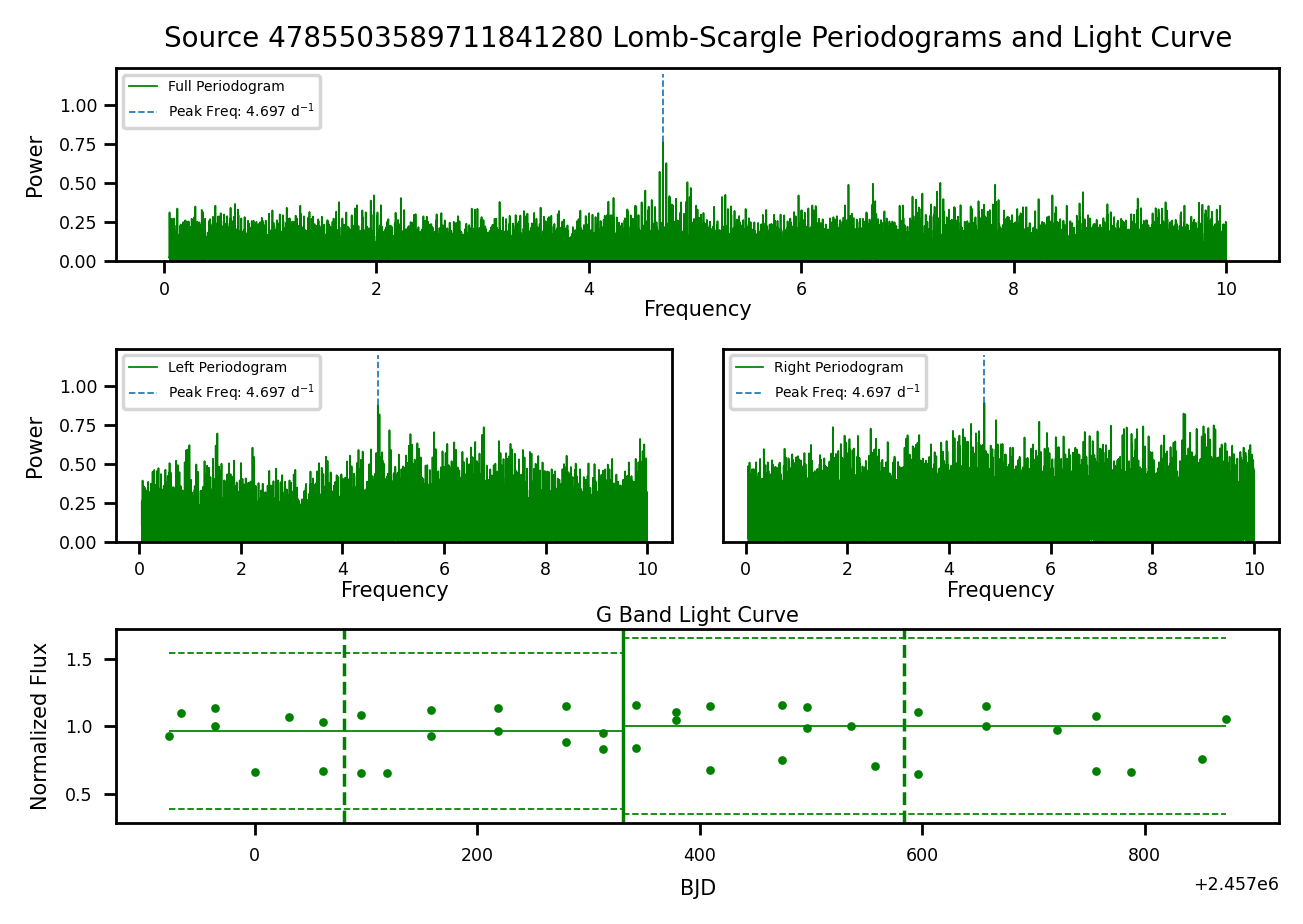

In [63]:
for row in lcClasses[lcClasses['best_class_name'] == 'ECL']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], save=False)
        break
    except:
        print(1)

In [260]:
importlib.reload(lightCurve)

<module 'lightCurve' from '../lightCurve.py'>

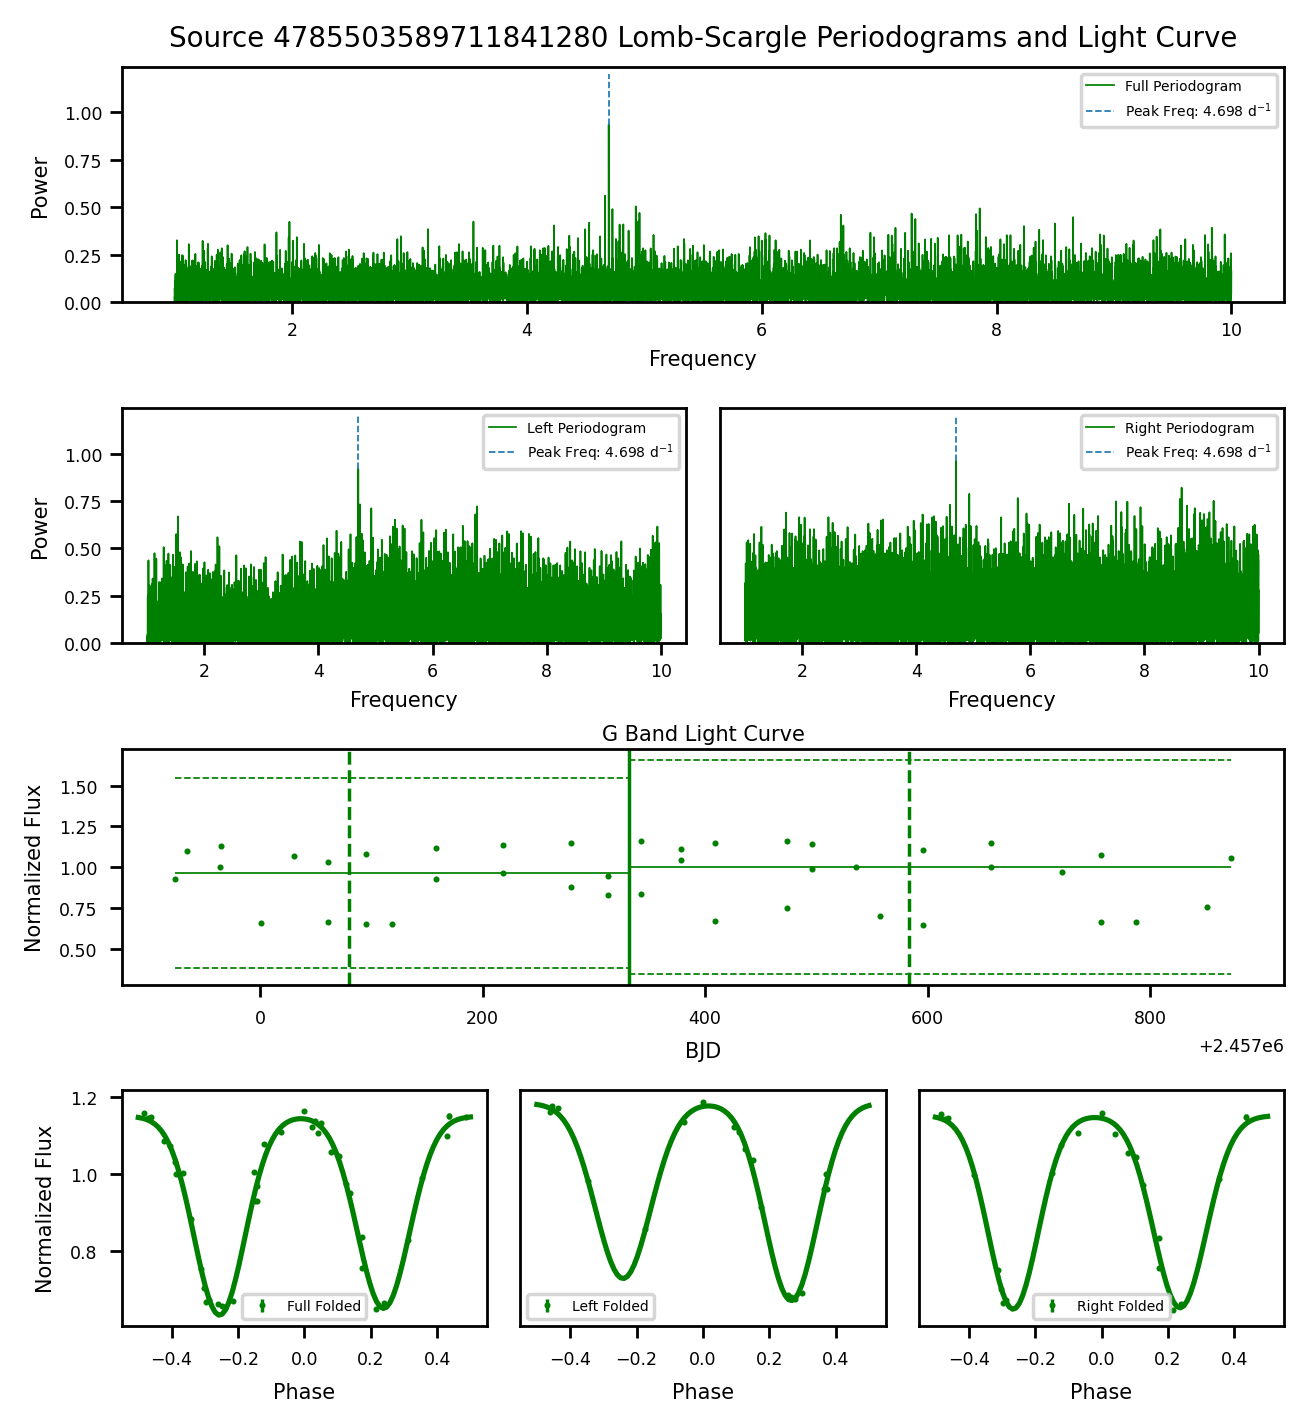

In [261]:
for row in lcClasses[lcClasses['best_class_name'] == 'ECL']:
    lcID = row['source_id']
    id_mask = stars_x['id'] == lcID
    try:
        lightCurve.comparePeriodFoldPlot(glcDict, lcID, stars_x[id_mask], c1_x[id_mask], min_freq=1, max_freq=10, save=False, ecl=True)
        break
    except:
        print(1)